# xDB Training

A notebook exploring the xDB dataset tier3 part for Building Segmentation Model and Damaged Classification Model

In [1]:
# In a Jupyter notebook or IPython environment, run this in the first cell
%load_ext autoreload
%autoreload 2

In [37]:
%reload_ext autoreload

In [3]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
# Define the transformation pipeline
def get_train_augmentation_pipeline(image_size=(256, 256)):
    transform = A.Compose([
        # Resize images and masks
        A.Resize(image_size[0], image_size[1], p=1.0),  # Ensure both image and mask are resized
        # Random horizontal flip
        A.HorizontalFlip(p=0.8),
        # Random vertical flip
        A.VerticalFlip(p=0.8),
        # Random rotation
        A.RandomRotate90(p=0.05),
        # Random brightness and contrast adjustments
        A.RandomBrightnessContrast(p=0.2),
        # Random contrast adjustment
        A.RandomGamma(p=0.2),
        # Random scale and aspect ratio change
        A.RandomSizedCrop(min_max_height=(image_size[0], image_size[1]), size=(image_size[0], image_size[1]), p=0.8, w2h_ratio=0.5),
        # Random blur
        A.GaussianBlur(p=0.2),
        # Convert to tensor (works for both image and mask)
        ToTensorV2()
    ])
    return transform

def get_val_augmentation_pipeline(image_size=(256, 256)):
    transform = A.Compose([
        # Resize images and masks
        A.Resize(image_size[0], image_size[1], p=1.0),  # Ensure both image and mask are resized
        ToTensorV2()
    ])
    return transform

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from datasets import xDB_Damaged_Building

origin_dir = "../data/xDB/tier3"

data_train  = xDB_Damaged_Building(
    origin_dir = origin_dir,
    mode="building",
    time="pre",
    transform=get_train_augmentation_pipeline(image_size=(512,512)),
    type="train",
    val_ratio=0.1, 
    test_ratio=0.1,
)

data_val  = xDB_Damaged_Building(
    origin_dir = origin_dir,
    mode="building",
    time="pre",
    transform=get_val_augmentation_pipeline(image_size=(512,512)),
    type="val",
    val_ratio=0.1, 
    test_ratio=0.1,
)

data_test  = xDB_Damaged_Building(
    origin_dir = origin_dir,
    mode="building",
    time="pre",
    transform=get_val_augmentation_pipeline(image_size=(512,512)),
    type="test",
    val_ratio=0.1, 
    test_ratio=0.1,
)

Loaded 5097 train labels.
Loaded 636 val labels.
Loaded 636 test labels.


In [13]:
from models import ResNet_UNET 

model = ResNet_UNET(
        in_channels=3,
        out_channels=2,
        backbone_name="resnet50",
        pretrained=True,
        freeze_backbone=False,
    )

In [14]:
import torch
from torchsummary import summary 
# Before training, wrap the model for Data Parallelism
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = torch.nn.DataParallel(model)

model.to("cuda")

summary(model, input_size=(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [15]:
from torch.utils.data import DataLoader
train_dl = DataLoader(data_train, batch_size=8, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)
val_dl = DataLoader(data_val, batch_size=8, shuffle=False, num_workers=8, pin_memory=True)

In [16]:
from torch.nn.modules.loss import _Loss
from typing import List

class Ensemble(_Loss):
    def __init__(
        self,
        list_losses: List[_Loss] = [],
        weights: List[float] = []
    ):
        super().__init__()
        self.list_losses = list_losses
        self.weights = weights

        assert len(list_losses) > 0, "List of losses cannot be empty."
        assert len(weights) == len(list_losses), "Weights must match the number of losses."

        # Normalize weights to sum to 1
        total_weight = sum(self.weights)
        assert total_weight > 0, "Weights must sum to a positive value."
        self.weights = [w / total_weight for w in self.weights]

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Computes the weighted ensemble loss.
        
        :param inputs: Predictions from the model.
        :param targets: Ground truth labels.
        :return: Weighted ensemble loss.
        """
        total_loss = 0.0
        for weight, loss_fn in zip(self.weights, self.list_losses):
            loss = loss_fn(inputs, targets)
            total_loss += weight * loss
        
        return total_loss


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from training import train 
from losses import SoftCrossEntropyLoss
from losses import DiceLoss, FocalLoss
from metrics import f1_score, iou_score, balanced_accuracy

mode = "multiclass"
reduction = "weighted"
class_weights = [0.1, 0.9]

optimizer = optim.AdamW(params=filter(lambda p: p.requires_grad, model.parameters()), lr=0.00015, weight_decay=1e-6)
params_opt = {}
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 11, 17, 25, 33, 47, 50, 60, 70, 90, 110, 130, 150, 170, 180, 190], gamma=0.5)

params_sc = {}
criterion = Ensemble(list_losses=[DiceLoss(mode=mode), FocalLoss(mode=mode)], weights= [1.0, 10.0]).cuda()
# Define Metrics 
metrics = [balanced_accuracy, f1_score, iou_score]

# Early Stopping 
early_stopping_params = {"patience":5, "trigger_times": 0}

torch.cuda.empty_cache()
train(
    model,
    train_dl=train_dl,
    valid_dl=val_dl,
    optimizer=optimizer,
    scheduler=scheduler,
    params_opt=params_opt,
    params_sc=params_sc,
    metrics=metrics,
    nb_epochs=55,
    loss_fn=criterion,
    experiment_name="xDB_ResNet50_Unet",
    log_dir="../runs",
    model_dir="../models",
    early_stopping_params = early_stopping_params,
    image_key="image",
    training_log_interval=5,
    verbose=False,
    is_mixed_precision=True, 
    reduction=reduction,
    class_weights=class_weights
)


In [18]:
test_dl = DataLoader(data_test, batch_size=5, shuffle=True)

In [19]:
input_test = next(iter(test_dl))
outputs = model.predict(input_test["image"].to("cuda"))

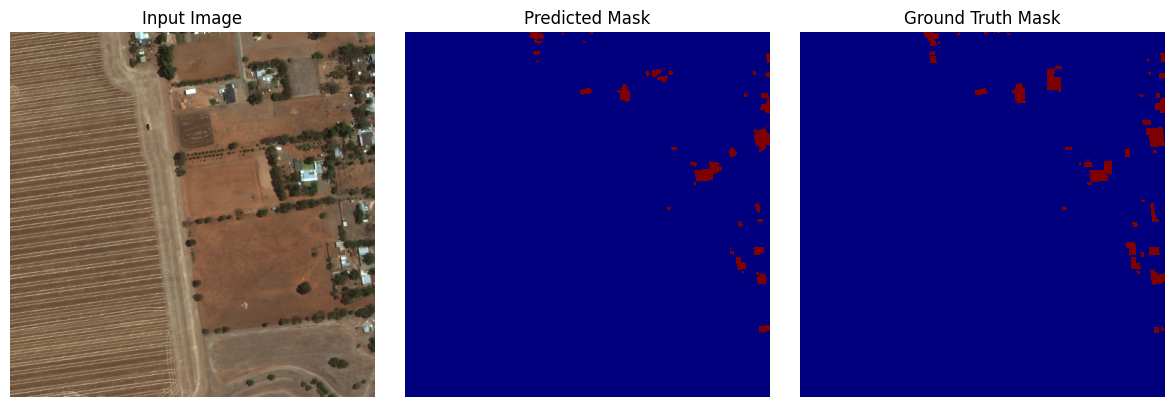

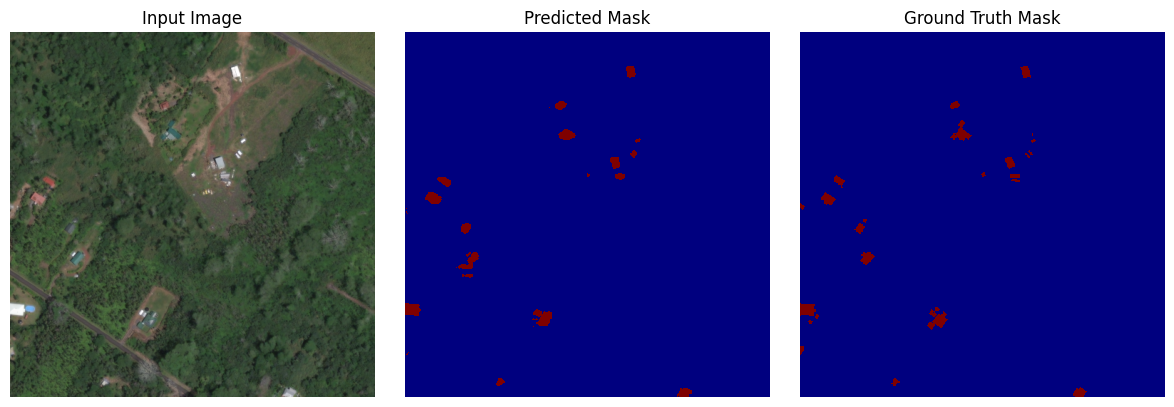

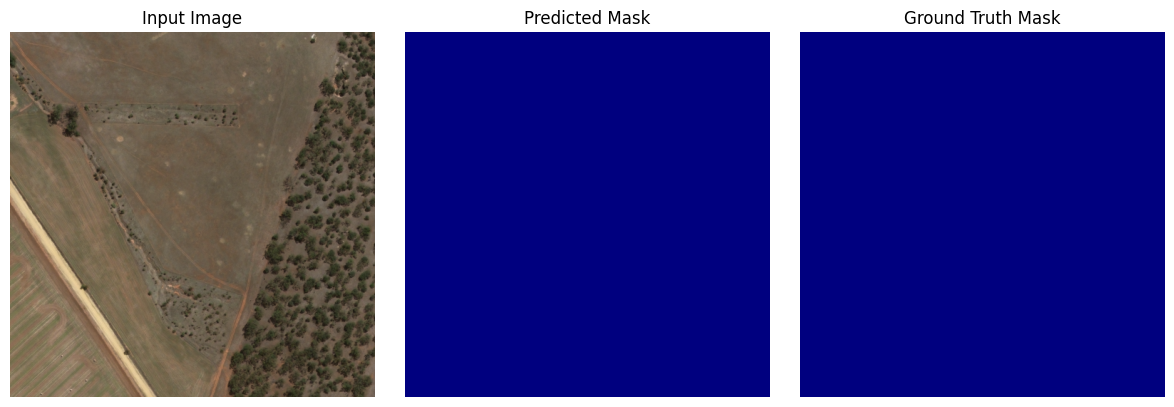

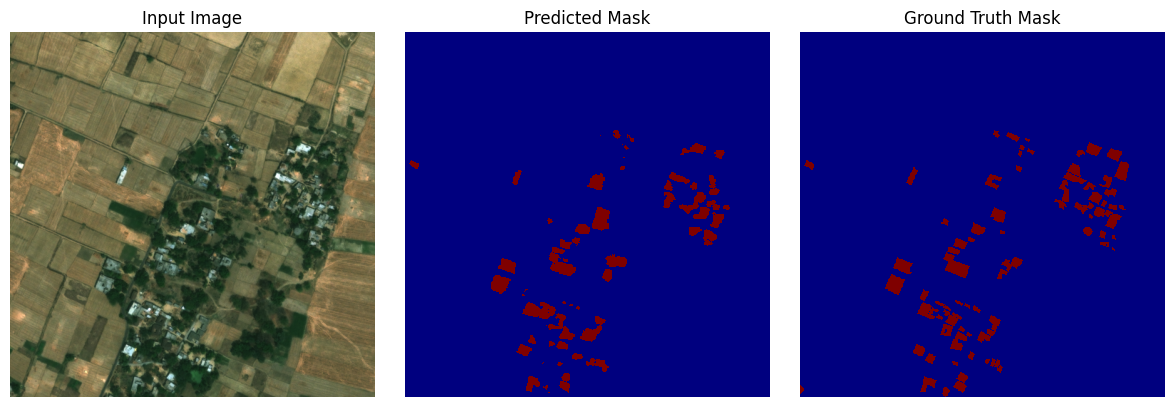

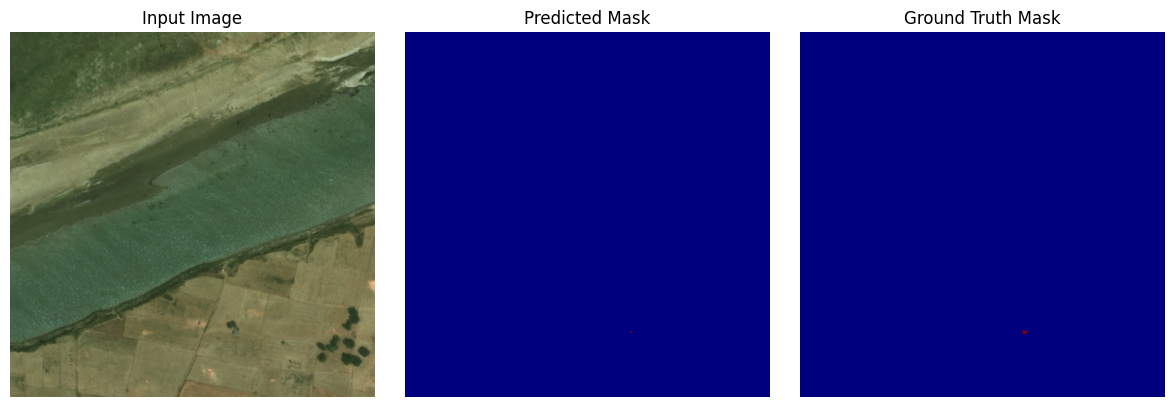

In [20]:
from utils import display_predictions_batch

display_predictions_batch(
    images=input_test["image"],
    mask_predictions=outputs,
    mask_labels=input_test["mask"]
    )

In [30]:
input_test["image"].shape

torch.Size([5, 3, 512, 512])

In [31]:
from training import augmentation_test_time
import numpy as np
# Define Albumentations augmentations
augmentations = [
    A.HorizontalFlip(p=1.0),  # Horizontal flip
    A.VerticalFlip(p=1.0)    # Vertical flip
]
outputs_tta = augmentation_test_time(model, batch=input_test, list_augmentations=augmentations, aggregation="mean", image_tag="image", device="cuda" )
outputs_tta = np.argmax(outputs_tta, axis=1) 

torch.Size([5, 3, 512, 512])
torch.Size([5, 3, 512, 512])


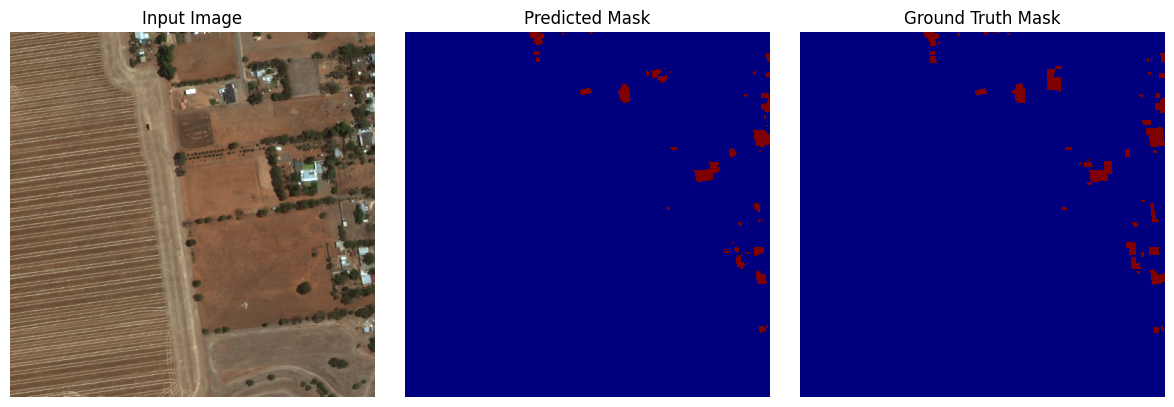

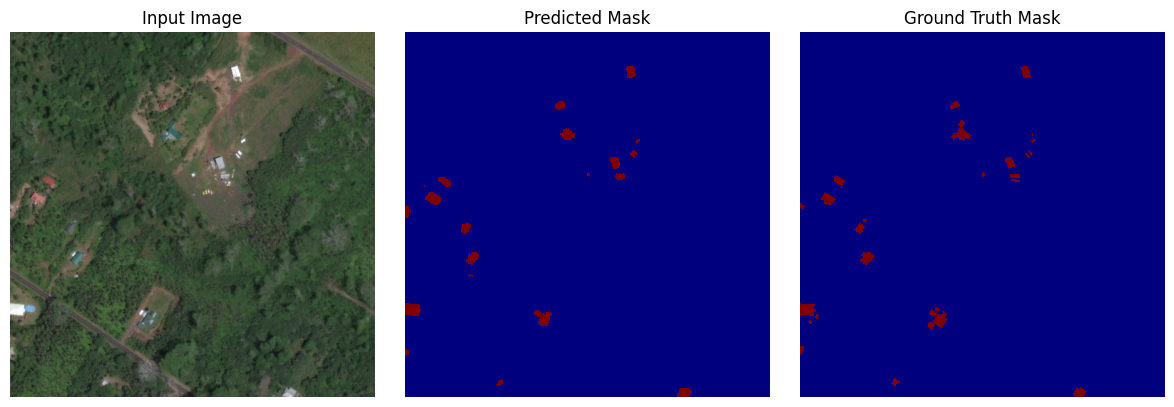

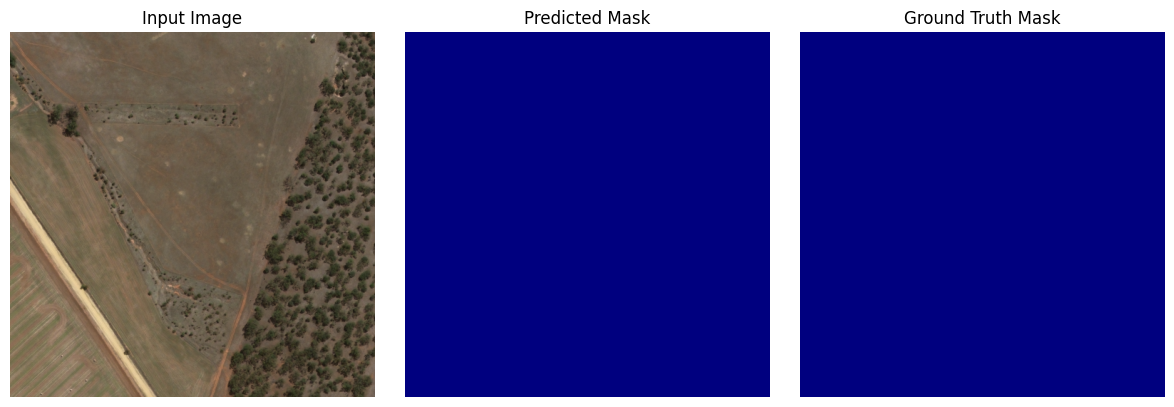

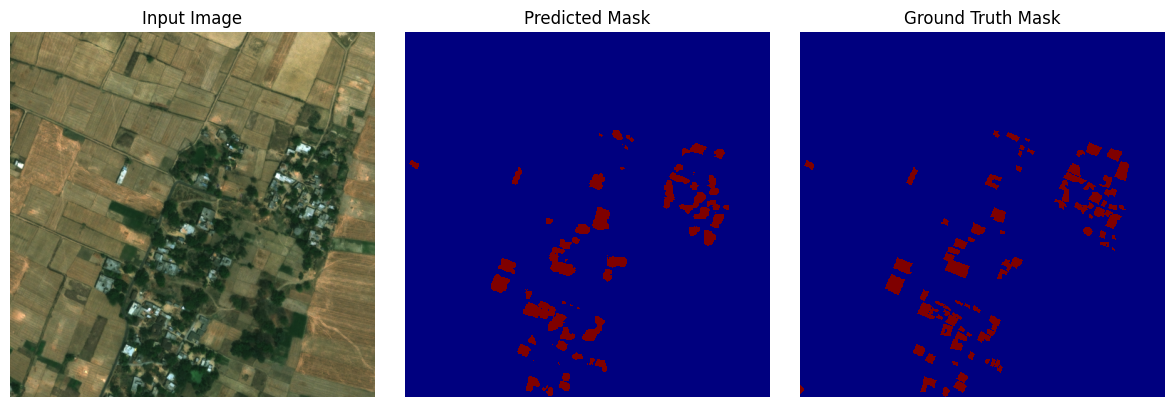

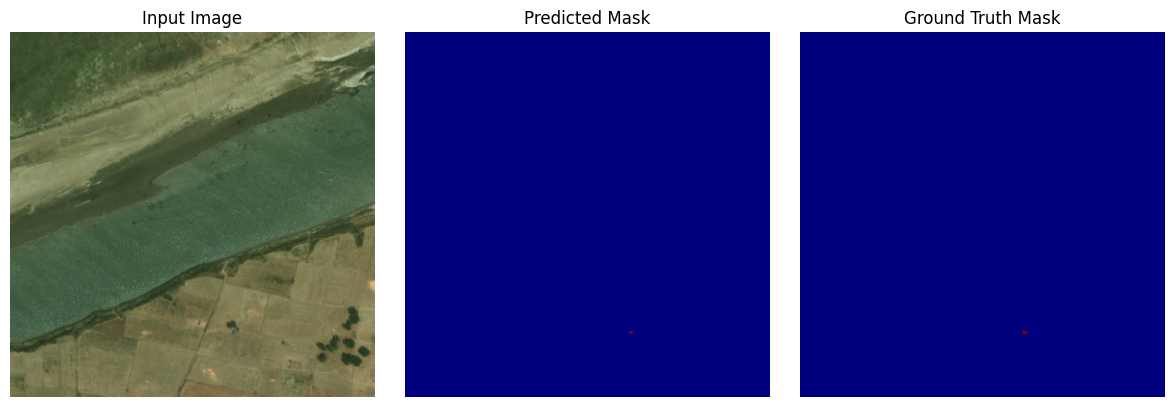

In [32]:
display_predictions_batch(
    images=input_test["image"],
    mask_predictions=outputs_tta,
    mask_labels=input_test["mask"]
    )

In [42]:
### Testing TTA efficiency 
from training import testing 

epoch_tloss, test_metrics = testing(
    model=model,
    test_dataloader=test_dl,
    loss_fn=criterion,
    metrics=metrics,
    image_key="image",
    verbose=True, 
    is_mixed_precision= False,
    num_classes= 2,
    reduction= "weighted",
    class_weights=[0.1, 0.9], 
    tta=False
)

Testing: 100%|██████████| 128/128 [03:27<00:00,  1.62s/batch, Loss=0.256]


In [43]:
print("Test Loss without TTA : ", epoch_tloss)
print("Metrics without TTA : ",test_metrics)

Test Loss without TTA :  0.2420090448884469
Metrics without TTA :  {'balanced_accuracy': tensor(0.8611), 'f1_score': tensor(0.7848), 'iou_score': tensor(0.6690)}


In [45]:
### Testing TTA efficiency 
from training import testing 

epoch_tloss, test_metrics = testing(
    model=model,
    test_dataloader=test_dl,
    loss_fn=criterion,
    metrics=metrics,
    image_key="image",
    verbose=True, 
    is_mixed_precision= False,
    num_classes= 2,
    reduction= "weighted",
    class_weights=[0.1, 0.9], 
    tta=True
)

Testing: 100%|██████████| 128/128 [07:37<00:00,  3.57s/batch, Loss=0.199]


In [46]:
print("Test Loss with TTA : ", epoch_tloss)
print("Metrics with TTA : ", test_metrics)

Test Loss with TTA :  0.19553206251852168
Metrics with TTA :  {'balanced_accuracy': tensor(0.8620), 'f1_score': tensor(0.7812), 'iou_score': tensor(0.6670)}


## Fine Tune Mask R CNN on xDB dataset - Building Footprint Segmentation 

In [104]:
from torchvision.transforms import v2

def get_augmentation_training_pipeline(target_size: tuple):
    """
    Creates a data augmentation pipeline that includes resizing.

    Parameters:
    - target_size (tuple): Desired output size (height, width).

    Returns:
    - torchvision.transforms.Compose: Augmentation pipeline.
    """
    return  v2.Compose([
        v2.RandomResizedCrop(size=target_size, antialias=True),
        v2.RandomHorizontalFlip(p=0.5),    # Randomly flip the image horizontally
        v2.RandomVerticalFlip(p=0.5),
        #v2.RandomRotation(degrees=15),     # Randomly rotate the image
        #v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors   
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])       
    ])

def get_augmentation_validation_pipeline(target_size: tuple):
    return v2.Compose([
        v2.Resize(size=target_size),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [106]:
# Test 
from datasets import xDB_Instance_Building
data_train  = xDB_Instance_Building(
    origin_dir = "../data/xDB/tier3",
    mode="building",
    time="pre",
    transform = get_augmentation_training_pipeline(target_size= (512,512)),
    type="train",
    val_ratio=0.1, 
    test_ratio=0.1,
    )

data_val  = xDB_Instance_Building(
    origin_dir =  "../data/xDB/tier3",
    mode="building",
    time="pre",
    transform=get_augmentation_validation_pipeline(target_size=(512,512)),
    type="val",
    val_ratio=0.1, 
    test_ratio=0.1,
)

Loaded 5097 train labels.
Loaded 636 val labels.


In [107]:
import math
import sys
import time
from collections import defaultdict

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision
from torchvision.ops.boxes import box_iou


# Utility to reduce loss dictionary across GPUs (for distributed training)
from training.utils import reduce_dict
from datasets.utils import custom_collate_fn

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10, scaler=None, writer=None):
    """
    Train the model for one epoch.

    Parameters:
        model (torch.nn.Module): The model to train.
        optimizer (torch.optim.Optimizer): The optimizer to use.
        data_loader (DataLoader): DataLoader for the training dataset.
        device (torch.device): Device to run the training on.
        epoch (int): Current epoch number.
        print_freq (int): Frequency of printing training stats.
        scaler (torch.cuda.amp.GradScaler): GradScaler for mixed precision training (optional).
        writer (SummaryWriter): TensorBoard writer for logging (optional).

    Returns:
        float: The average loss over the epoch.
    """
    model.train()
    lr_scheduler = None
    if epoch == 0:
        # Warm-up learning rate for the first epoch
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    print(f"Starting epoch {epoch}...")
    running_loss = 0.0

    for i, (images, targets) in enumerate(data_loader):
        # Prepare data for training
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        # Forward pass with optional mixed precision
        with torch.amp.autocast(device_type=device, enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Reduce loss for logging
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        loss_value = losses_reduced.item()

        # Update running loss
        running_loss += loss_value

        # Check for NaN or infinite loss
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(f"Reduced Loss Dictionary: {loss_dict_reduced}")
            sys.exit(1)

        # Backpropagation and optimization
        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        # Step learning rate scheduler if present
        if lr_scheduler is not None:
            lr_scheduler.step()

        # Logging
        if i % print_freq == 0 or i == len(data_loader) - 1:
            global_step_number = len(data_loader) * epoch + i
            avg_loss = running_loss / (i + 1)
            print(
                f"Epoch [{epoch}], Batch [{i}/{len(data_loader)}]: "
                f"Loss: {loss_value:.4f}, Avg Loss: {avg_loss:.4f}, "
                f"LR: {optimizer.param_groups[0]['lr']:.6f}"
            )
            if writer:
                writer.add_scalar("Training/Loss", avg_loss, global_step_number)
                writer.add_scalar("Learning Rate", optimizer.param_groups[0]['lr'], global_step_number)

    avg_epoch_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch} finished. Average Loss: {avg_epoch_loss:.4f}")
    return avg_epoch_loss


@torch.inference_mode()
def evaluate(model, data_loader, device):
    """
    Evaluate a Mask R-CNN model on a custom dataset.

    Parameters:
        model (torch.nn.Module): The Mask R-CNN model to evaluate.
        data_loader (DataLoader): DataLoader for the evaluation dataset.
        device (torch.device): Device to run the evaluation on.

    Returns:
        dict: A dictionary containing instance-level and segmentation-level metrics.
    """
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()

    # Initialize metrics storage
    instance_metrics = defaultdict(list)
    segmentation_metrics = defaultdict(list)

    # Evaluation loop
    for i, (images, targets) in tqdm(enumerate(data_loader), total=len(data_loader), desc="Evaluating"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(cpu_device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        # Get model predictions
        model_time = time.time()
        outputs = model(images)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        # Metric calculations
        for output, target in zip(outputs, targets):
            # Detection metrics
            pred_boxes = output["boxes"]
            pred_scores = output["scores"]
            pred_labels = output["labels"]
            true_boxes = target["boxes"]
            true_labels = target["labels"]
            precision, recall, f1_score = calculate_detection_metrics(
                pred_boxes, pred_scores, pred_labels, true_boxes, true_labels
            )
            instance_metrics["precision"].append(precision)
            instance_metrics["recall"].append(recall)
            instance_metrics["f1_score"].append(f1_score)

            # Segmentation metrics
            pred_masks = (output["masks"] > 0.5).squeeze(1)  # Binarize predicted masks
            true_masks = target["masks"]


            iou, dice = calculate_segmentation_metrics(pred_masks, true_masks)
            segmentation_metrics["iou"].append(iou)
            segmentation_metrics["dice"].append(dice)

    # Aggregate metrics
    aggregated_metrics = {
        "instance": {k: torch.tensor(v).mean().item() for k, v in instance_metrics.items()},
        "segmentation": {k: torch.tensor(v).mean().item() for k, v in segmentation_metrics.items()},
    }

    print("Evaluation complete.")
    torch.set_num_threads(n_threads)
    return aggregated_metrics


def calculate_detection_metrics(pred_boxes, pred_scores, pred_labels, true_boxes, true_labels, iou_threshold=0.5):
    """
    Calculate precision, recall, and F1 score for detection.

    Parameters:
        pred_boxes (Tensor): Predicted bounding boxes.
        pred_scores (Tensor): Confidence scores for each box.
        pred_labels (Tensor): Predicted labels.
        true_boxes (Tensor): Ground truth boxes.
        true_labels (Tensor): Ground truth labels.
        iou_threshold (float): IoU threshold for true positive matching.

    Returns:
        tuple: Precision, recall, F1 score.
    """
    ious = box_iou(pred_boxes, true_boxes)
    matches = ious > iou_threshold

    true_positive = matches.sum().item()
    false_positive = pred_boxes.size(0) - true_positive
    false_negative = true_boxes.size(0) - true_positive

    precision = true_positive / (true_positive + false_positive + 1e-6)
    recall = true_positive / (true_positive + false_negative + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

    return precision, recall, f1_score


def calculate_segmentation_metrics(pred_masks, true_masks, iou_threshold=0.5):
    """
    Calculate IoU and Dice coefficient for segmentation masks.

    Parameters:
        pred_masks (Tensor): Predicted binary masks (N, H, W).
        true_masks (Tensor): Ground truth binary masks (M, H, W).
        iou_threshold (float): Threshold for determining matches (optional for reporting).

    Returns:
        tuple: IoU and Dice coefficient.
    """
    pred_masks = pred_masks.bool()
    true_masks = true_masks.bool()

    # Compute pairwise IoU
    iou_matrix = []
    for pred in pred_masks:
        row = []
        for true in true_masks:
            intersection = (pred & true).sum().item()
            union = (pred | true).sum().item()
            row.append(intersection / (union + 1e-6))
        iou_matrix.append(row)
    
    iou_matrix = torch.tensor(iou_matrix)

    # Match masks using IoU threshold
    matched_preds = set()
    matched_truths = set()
    for pred_idx, iou_row in enumerate(iou_matrix):
        max_iou, truth_idx = iou_row.max(0)
        if max_iou > iou_threshold and truth_idx not in matched_truths:
            matched_preds.add(pred_idx)
            matched_truths.add(truth_idx)

    # Calculate metrics
    intersection = torch.stack([pred_masks[pred] & true_masks[truth] for pred, truth in zip(matched_preds, matched_truths)])
    union = torch.stack([pred_masks[pred] | true_masks[truth] for pred, truth in zip(matched_preds, matched_truths)])
    dice_coeff = (2 * intersection.sum() / (intersection.sum() + union.sum() + 1e-6)).item()
    iou = (intersection.sum() / (union.sum() + 1e-6)).item()

    return iou, dice_coeff



In [108]:
import torch
from models import Maskrcnn
from datasets.utils import custom_collate_fn  # Assuming your custom collate function is defined here

# Check if a GPU is available, else use the CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on: {device}")

scaler = torch.amp.GradScaler()

# Initialize the Mask R-CNN model
model = Maskrcnn(num_classes=2, hidden_layer_dim=256, pretrained=True)
model.to(device)

# Define training and validation DataLoaders
train_dl = torch.utils.data.DataLoader(
    data_train,  # Replace with your training dataset
    batch_size=1,
    shuffle=True,
    collate_fn=custom_collate_fn,
    pin_memory=True
)

valid_dl = torch.utils.data.DataLoader(
    data_val,  # Replace with your validation dataset
    batch_size=1,
    shuffle=False,  # No need to shuffle validation data
    collate_fn=custom_collate_fn,
    pin_memory=True
)

# Prepare the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# Define a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,  # Decrease LR every 3 epochs
    gamma=0.1     # Multiply LR by 0.1 at each step
)

# Training parameters
num_epochs = 2  # Set to 2 for now; can increase for better results

print("Setup complete! Ready to start training.")


Training on: cuda
Setup complete! Ready to start training.


In [ ]:
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=1000, scaler=scaler)
    eval_metrics = evaluate(model, valid_dl, device)
    print(f"Epoch {epoch + 1}/{num_epochs} | Training Loss: {train_loss:.4f}")
    print(f"Validation Metrics: {eval_metrics}")
    # Step the learning rate scheduler
    lr_scheduler.step()

Starting epoch 0...
Epoch [0], Batch [0/5097]: Loss: 0.1314, Avg Loss: 0.1314, LR: 0.000000
